## MIS

### Basic Approach

 1. Use multiple sampling techniques to do the sampling, use the weighted sum as the result.
 2. For complex integrand, you don't know which sampling technique is the best, MIS will perform much better than a bad match of sampling technique.
 3. Restriction 1: weight sum up to 1.
 4. Restriction 2: Weight equal to 0 where possibility is 0.
 
### Strategies of weighting function

 1. Balance heuristic:
 

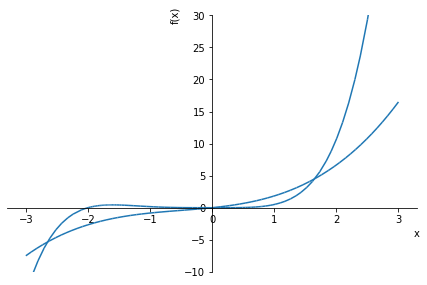

In [8]:
from sympy import *
import numpy as np

x, y, f1, f2, if1, if2, fsum, fmul = symbols('x y f1 f2 if1 if2 fsum fmul')
pdf1, pdf2 = symbols('pdf1 pdf2')

f1 = x ** 2
f2 = x + 1

if1 = integrate(f1)
if2 = integrate(f2)

fsum = if1 + if2
fmul = if1 * if2

from sympy.plotting import plot

p1 = plot(fsum, (x, -3, 3), ylim=(-10, 30), show=False)
p2 = plot(fmul, (x, -3, 3), ylim=(-10, 30), show=False)

p1.extend(p2)

p1.show()

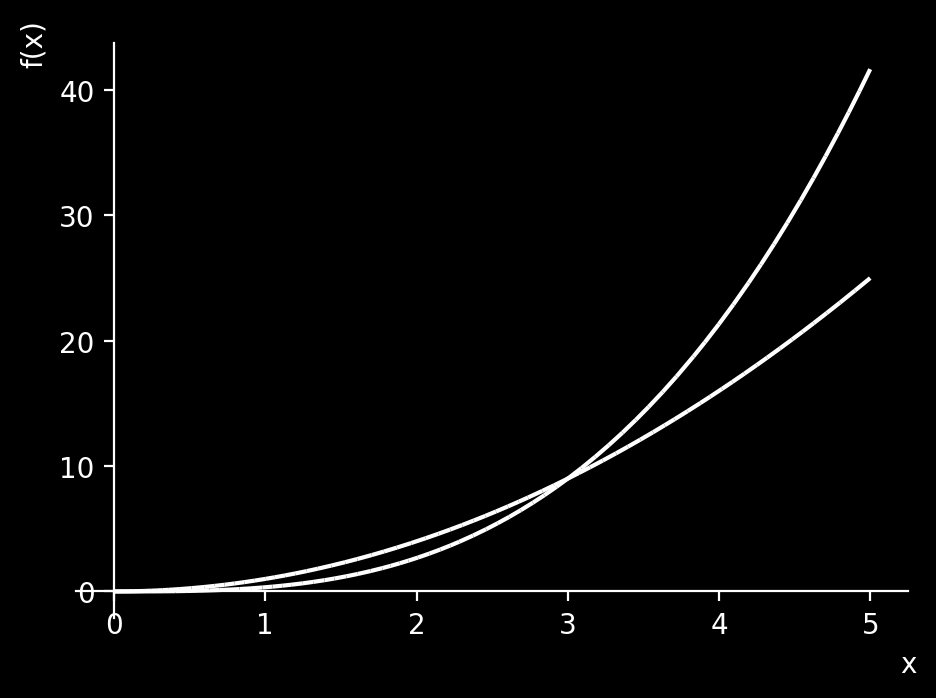

4

In [6]:
# Monte Carlo basics

from sympy import *

x, y, z, f1, f2 = symbols('x y z f1 f2')

# Surpose f1 is a function hard to integrate
f1 = x ** 2
integrated_f1 = integrate(f1)
p1 = plot(integrated_f1, (x, 0, 5), show=False)
p2 = plot(f1, (x, 0, 5), show=False)
p1.extend(p2)
p1.show()

f1.subs(x, 2)